In [401]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time

# FUNCTIONS

In [402]:
def initialize_data(file_name,file_extension):
    
    # function used to import data and divide features (X) from labels (y) (i.e. the output of the function)
    
    '''
    INPUT:
    file_name=string containing the name of the dataset (e.g. 'a1a')
    file_extension=string containing the extension of the dataset file (e.g. 'txt')
    
    '''
    
    data = datasets.load_svmlight_file(file_name+'.'+file_extension) 
    X = np.asarray(data[0].todense())
    y = np.array(data[1])
    
    return X,y

In [403]:
def loss_regression(pred,y_true,F,lr):
    # sum of squared errors loss
    
    loss =  np.mean(1/2*((F+lr*pred)-y_true)**2)
    
    return loss
    

In [404]:
def loss_classification(pred,y_true,F,lr):
    # cross-entropy loss 
    
    loss = np.mean(np.log(1 + np.exp(np.nan_to_num(-(F) * y_true))))
    return loss
    ''' 
    alternative loss (not working properly, different from Lu et al. 2020)
    m = len(y_true)
    loss = -(1/m) *(np.sum(y_true * np.log(F+lr*pred) + (1 - y_true) * np.log(1 - (F+lr*pred))))
    '''


In [405]:
def get_pseudo_residuals(y,F):
    r = np.nan_to_num(np.exp(-y * F))
    pseudo_residuals = (y * r / (1 + r))
    
    return pseudo_residuals

### GBM

In [406]:
def fit_GBM(X_train, y_train, nr_WL=100,depth=4, lr=0.01,is_regression=1): 

    '''
    INPUT:
    X_train= training data
    y_train= training labels
    nr_WL= number of weak learners (WL) (NOTE: we use decision trees as WL)
    depth= maximum depth of each WL (=4 as in Lu et al. 2020 source code)
    lr= learning rate (fixed, as in Lu et al. 2020)
    is_regression = if you want to perform regression put it =1. Else you perform classification
    '''

    # Initialization
    nr_samples, nr_features = X_train.shape
    WLs = [] #vector containing the information for each weak learner used
    F = np.zeros(nr_samples)  # F is our ensemble of WLs. Here we will store its predictions
    lossVec=np.zeros(nr_WL) # Here we will store the values of the loss function


    for t in range(nr_WL): # We iterate for every WL we want to fit

        # Fit a weak learner to the pseudo_residuals, which are computed as gradient(Loss(y, F))
        if is_regression == 1:
            pseudo_residuals = y_train-F
        else:
            pseudo_residuals = get_pseudo_residuals(y_train, F)
        WL = DecisionTreeRegressor(max_depth=depth) # our WL (i.e. a decision tree) is initialized 
        WL.fit(X_train, pseudo_residuals) # WL is fitted using pseudo_residuals
        WL_pred = WL.predict(X_train) # WL's prediction
        
        if is_regression==1:
            loss = loss_regression(WL_pred,y_train,F,lr)
        else:
            loss = loss_classification(WL_pred,y_train,F,lr)
        
        lossVec[t] = loss # we register the loss in the loss vector

        # here we update the predictions of the ensemble
        F += lr * WL_pred
        
        # here we append to the WL vector the weak learner and the learning rate
        WLs.append((lr, WL))

    return WLs,lossVec

    '''
    OUTPUT:
    WLs = vector containing the information for each weak learner used.
    in particular : learning rate (fixed), the WL model
    lossVec = vector containing loss values for each fitting iteration "t"
    '''



In [407]:
def predict_GBM(X_test, y_test, WLs, is_regression=1):

    '''
    INPUT:
    X_test= testing data
    y_test= testing labels
    WLs = vector containing the information for each weak learner used for training
    is_regression = if you want to perform regression put it =1. Else you perform classification
    '''
    
    # Initialization

    F = np.zeros((X_test.shape[0], )) # initialization of the predictions vector
    lossVec=np.zeros(len(WLs)) # initialization of the loss vector on testing data 

    counter=0 # initialization of the counter

    for lr, WL in WLs:
        
        WL_pred = WL.predict(X_test) # prediction of the best fitting tree
        
        F += lr * WL.predict(X_test) # updating the ensemble model
        
        # computing loss
        if is_regression==1:
            lossVec[counter] = loss_regression(WL_pred,y_test,F,lr)
        else:
            lossVec[counter] = loss_classification(WL_pred,y_test,F,lr)

        counter +=1 #updating the counter
        
        
    # computing predictions in case of classification task 
    if is_regression==1:
        pred_discrete = np.NAN
    else:
        pred_discrete = np.where(1/(1 + np.exp(-F))>.5, 1, -1)

    return lossVec, pred_discrete
    
    '''
    OUTPUT:
    lossVec = vector containing loss values for each fitting iteration "t"
    pred_discrete = classification of the test data in the case of  classification task 
    '''

### AGBM

In [408]:
def fit_AGBM(X_train, y_train, nr_WL=100, depth=4, lr=0.01, gamma=0.1, is_regression=0):

    '''
    INPUT:
    X_train= training data
    y_train= training labels
    nr_WL= number of weak learners (WL) (NOTE: we use decision trees as WL)
    depth= maximum depth of each WL (=4 as in Lu et al. 2020 source code)
    lr= learning rate (fixed, as in Lu et al. 2020)
    gamma = accelleration-related parameter
    is_regression = if you want to perform regression put it =1. Else you perform classification
    '''
    # Initialization
    nr_samples, nr_features = X_train.shape
    WLs_AGBM = [] #vector containing the information for each weak learner used
    lossVec=np.zeros(nr_WL) # Here we will store the values of the loss function
    
    # initialization of our ensembles of WLs
    F = np.zeros(nr_samples)  # F is the ensemble used for predictions
    H = np.zeros(nr_samples)  # H is the "accellerator" ensemble
    G = np.zeros(nr_samples)  # G is a linear combination of F and H
    
    
 

    for t in range(nr_WL): # We iterate for every WL we want to fit
        
        theta=2/(t+2)  # the function theta changes as a function of the 
                             # iteration number of the algorithm (i.e. "t")

        # STEP 1) compute a linear combination of F and H
        G = ((1-theta) * F) + (theta*H) 
        
        

        # STEP 2) compute pseudo-residuals
        if is_regression == 1:
            pseudo_residuals = y_train-G
        else:
            pseudo_residuals = get_pseudo_residuals(y_train, G)
        

        # STEP 3) find the best weak learner for pseudo-residuals (i.e. WL_1)
        WL_1 = DecisionTreeRegressor(max_depth=depth)
        
        WL_1.fit(X_train, pseudo_residuals)
        
        WL_1_out = WL_1.predict(X_train) #prediction of the best fitting tree
        
        if is_regression==1:
            lossVec[t] = loss_regression(WL_1_out,y_train,G,lr)
        else:
            lossVec[t] = loss_classification(WL_1_out,y_train,G,lr)
         # loss computation is done
        # considering the F update of the current iteration (see step 4)

        # STEP 4) update the model F
        F = G + (lr * WL_1_out)

        # STEP 5) update the corrected residuals
        if t==0:
            pseudo_residuals_corr = pseudo_residuals
        else:
            pseudo_residuals_corr = pseudo_residuals - ((t+1)/(t+2))*(pseudo_residuals_corr-WL_2_out)
            # nota che nel codice mareva lu fa "-" al posto di più


        # STEP 6) find the best weak learner for corrected pseudo-residuals (i.e. WL_2)
        WL_2 = DecisionTreeRegressor(max_depth=depth)
        WL_2.fit(X_train,pseudo_residuals_corr)
        WL_2_out = WL_2.predict(X_train)

        # STEP 7) update the momentum model H
        H = H + (gamma*lr/theta)*WL_2_out
        
        # here we append to the WL vector the two weak learner models 
        WLs_AGBM.append((WL_1,WL_2))

    return WLs_AGBM,lossVec
    #DEBUG OUTPUTS: Fmatrix,Hmatrix,Gmatrix,FGBMmatrix
    '''
    OUTPUT:
    WLs_AGBM = vector containing the information for each weak learner used.
    in particular : WL_1 model, WL_2 model
    lossVec = vector containing loss values for each fitting iteration "t"
    '''

In [409]:
def predict_AGBM(X_test, y_test, WLs, lr=0.01, gamma=0.1, is_regression=0):
    '''
    INPUT:
    X_test= testing data
    y_test= testing labels
    WLs = vector containing the information for each weak learner used for training
    lr = (fixed) learning rate
    is_regression = if you want to perform regression put it =1. Else you perform classification
      '''
    
    # Initialization
    nr_samples, nr_features = X_test.shape
    lossVec=np.zeros(len(WLs)) # Here we will store the values of the loss function
    
    # initialization of our ensembles of WLs
    F = np.zeros(nr_samples)  # F is the ensemble used for predictions
    H = np.zeros(nr_samples)  # H is the "accellerator" ensemble
    G = np.zeros(nr_samples)  # G is a linear combination of F and H
 
    counter= 0
    
    
    
    for WL_1, WL_2 in WLs:
        
        theta=2/(counter+2)  # the function theta changes as a function of the 
                             # iteration number of the algorithm (i.e. the "m" variable)
        
        G = ((1-theta) * F) + (theta*H) 
    
        WL_1_out = WL_1.predict(X_test) # prediction of the best fitting tree
        G = ((1-theta) * F) + (theta * H) # compute linear combination of F and H
        F = G + lr * WL_1_out # updating  F 
        H += (gamma*lr/theta)*WL_2.predict(X_test) # Updating H 
        
        # computing loss
        if is_regression==1:
            lossVec[counter] = loss_regression(WL_1_out,y_test,G,lr)
        else:
            lossVec[counter] = loss_classification(WL_1_out,y_test,G,lr)
        
        # updating the  counter  
        counter +=1 
        
        # computing predictions in the case of classification task 
        if is_regression==1:
            pred_discrete = np.NAN
        else:
            pred_discrete = np.where(1/(1 + np.exp(-F))>.5, 1, -1)


    return lossVec,pred_discrete

    '''
    OUTPUT:
    lossVec = vector containing loss values for each fitting iteration "t"
    pred_discrete = classification of the test data in the case of  classification task 
    '''

### RGBM

In [410]:
def fit_RGBM(X_train, y_train, nr_WL=50, depth=1,lr=4,  j = 1, is_regression=0, d=0.0001): #lr=0.01,
    
    '''
    INPUT:
    X_train = training data
    y_test = training labels
    nr_WL = number of weak learners (WL) (NOTE: we use decision trees as WL)
    depth = maximum depth of each WL (=1 as in Lu, Mazumder. 2020 source code)
    lr = learning rate (constant step-size specified a-priori)
    j = dimensionality of the subset of features
    is_regression = if you want to perform regression put it =1. Else you perform classification
    '''
    
    # Initialize
    nr_samples, nr_features = X_train.shape # computing the shape of data 
    WLs_RGBM = [] # list of outputs 
    F = np.zeros(nr_samples) # Null model initialization
    lossVec=np.zeros(nr_WL) # Here we will store the values of the loss function
    
    
    for t in range(nr_WL):
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        #pseudo_residuals = get_pseudo_residuals(y_train,F,is_regression)
        
        # STEP 1): Compute pseudoresidual  
        
        temp = np.exp(-y_train*F)
        pseudo_residuals = y_train*temp/(1+temp) + 0.0001*(y_train-F)
        

        # STEP 2): Pick a random subset J of weak learners by some rule
        
        set_of_features = np.random.choice(nr_features, j, replace=False)
        J = X_train[:,set_of_features]
        
        # STEP 3): find the best weak learner for pseudo-residuals
        
        WL = DecisionTreeRegressor(max_depth=depth) # our WL (i.e. a decision tree) is initialized 
        WL.fit(J, pseudo_residuals) # WL is fitted using pseudo_residuals
        WL_pred = WL.predict(J) # WL's prediction
        
        # computing loss 
        if is_regression==1:
            loss = loss_regression(WL_pred,y_train,F,lr)
        else:
            #computing loss for classification task
            loss = np.mean(np.log(1+np.exp(-F*y_train)) + 0.0001/2*(F-y_train)**2)            
            
        lossVec[t] = loss # we register the loss in the loss vector
        
        # STEP 5): here we update the predictions of the ensemble
        F += lr * WL_pred
        
        # here we append to the WL vector the weak learner and the learning rate
        WLs_RGBM.append((lr, WL, set_of_features))
        
        
    return WLs_RGBM,lossVec
    '''
    OUTPUT:
    WLs_AGBM = vector containing the information for each weak learner used.
    in particular : lr, WL, set_of_features
    lossVec = vector containing loss values for each fitting iteration "t"
    '''

In [411]:
def fit_RGBM_time(X_train, y_train, nr_WL=50, depth=1,  j = 1,lr = 4, is_regression=1, secs = 1): #lr=0.01,
    
    '''
    INPUT:
    X_train= training data
    y_train= training labels
    nr_WL= number of weak learners (WL) (NOTE: we use decision trees as WL)
    depth= maximum depth of each WL (=1 as in Lu et al. 2020 source code)
    j= number of feature randomly selected (parameter t as in Lu, Haihao and Rahul Mazumder 2020)
    lr= learning rate (fixed, as in Lu et al. 2020)
    is_regression = if you want to perform regression put it =1. Otherwise you perform classification
    secs = number of training seconds
    '''
    
    # Initialize
    nr_samples, nr_features = X_train.shape
    WLs_RGBM = [] #vector containing the information for each weak learner used
    F = np.zeros(nr_samples) # Null model initialization
    lossVec = [] # Here we will store the values of the loss function
    
    start = time.time() #start measuring the time
    elapsed = time.time() - start 
    timeVec = [] #vector containing the time steps for plotting
    t = 0 #counter for the iterations
    
    while elapsed < secs:
        
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        
        if is_regression==1: #case 1: we are doing regression
            pseudo_residuals = y_train - (F)
        else: #case 2:we are doing classification
            r = np.nan_to_num(np.exp(-y_train * F))
            pseudo_residuals = y_train * r / (1 + r) 
        #pseudo_residuals = y_train - F
        # Random selection of the features for the subset
        inds = np.random.uniform(0, nr_features, size = j) #Extraction from a Uniform distribution
        inds = inds.astype(int)
        J = X_train[:,inds] #Subsetting
        
        # Fitting weak learner
        WL = DecisionTreeRegressor(max_depth=depth) # our WL (i.e. a decision tree) is initialized 
        WL.fit(J, pseudo_residuals) # WL is fitted using pseudo_residuals
        WL_pred = WL.predict(J) # WL's prediction
        
        
        if is_regression==1:
            loss  = np.mean(1/2*((F+lr*WL_pred)-y_train)**2)
        else:            
            loss = np.mean(np.log(1+np.exp(-F*y_train)) + 0.0001/2*(F-y_train)**2)
            #loss = loss_classification(WL_pred,y_train,F,lr)
        
            
        # we register the loss and the time for each iteration
        lossVec.append(loss) 
        timeVec.append(elapsed)
        
        # here we update the predictions of the ensemble
       
        F += lr * WL_pred
        
        
        # here we append to the WL vector the weak learner, the learning rate and the indices
        WLs_RGBM.append((lr, WL, inds))
        t += 1 # update the iteration counter
        elapsed = time.time() - start # update the time status
    
    # transforming lists in arrays
    lossVec = np.array(lossVec)  
    timeVec = np.array(timeVec)
    return WLs_RGBM ,lossVec, t, timeVec
    
    '''
    OUTPUT:
    WLs_RGBM = vector containing the information for each weak learner used
    lossVec = vector containing loss values for each fitting iteration "t"
    t = iteration counter
    timVec = vector containing the time steps for plotting
    '''

In [412]:
def predict_RGBM(X_test, y_test, WLs, is_regression=1):
    
    '''
    INPUT:
    X_test= testing data
    y_test= testing labels
    WLs = vector containing the information for each weak learner used for training
    is_regression = if you want to perform regression put it =1. Else you perform classification
    '''
    
    F = np.zeros((X_test.shape[0], )) # initialization of the predictions vector
    lossVec=np.zeros(len(WLs)) # initialization of the loss vector on testing data 

    counter=0 #initialization of the counter

    for lr, WL, j in WLs:
        # pick a random subset of features using indices (i.e j) stored previously during train 
        J = X_test[:,j]
        WL_pred =  WL.predict(J)
        if is_regression==1:
            lossVec[counter] = loss_regression(WL_pred,y_test,F,lr)
        else:
            # computing loss for classification task 
            lossVec[counter] = np.mean(np.log(1+np.exp(-F*y_test)) + 0.0001/2*(F-y_test)**2) 
        
        # updating of the ensemble
        F += lr * WL.predict(J)
        
        # updating of the counter
        counter +=1
        
    if is_regression==1:
        pred_discrete = np.NAN
    else:
        pred_discrete = np.where(1/(1 + np.exp(-F))>.5, 1, -1)
        

    return lossVec, pred_discrete
   
    '''
    OUTPUT:
    lossVec = vector containing loss values for each fitting iteration "t"
    pred_discrete = classification of the test data in the case of  classification task 
    '''


In [413]:
def train_test_loss(X, y, nr_WL_value = 30, gamma_value = 0.3, nr_randomizations=5, lr_value = 0.1, is_reg=0):
    
    # with this function we evaluate the train and test loss of GBM and AGBM on different train-test splits of the data
    # (nr_randomizations=5). For each training and testing we save the last value of the loss. From then we then calculate
    # the average loss and the standard error of the mean (n=5).
    
    
    # INITIALIZATION:
    # these vectors will collect the last loss values obtained using either GBM or AGBM on Train (TR) or test (TE) data
    GBM_lastLoss_TR = [] 
    AGBM_lastLoss_TR = []
    GBM_lastLoss_TE = []
    AGBM_lastLoss_TE = []


    for n in range(nr_randomizations): #for each data splitting...
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n) # do the split with a
        # different random state each time (train-test => 80-20 %)
        
        # GBM FIT AND PREDICT
        WLs_logit,lossVec_logit = fit_GBM(X_train, y_train, lr=lr_value, is_regression = is_reg , nr_WL = nr_WL_value)
        # we fit the GBM...
        GBM_lastLoss_TR.append(lossVec_logit[-1]) #... and append the last value of the training loss to the related vector
        lossVecPred_logit,pred_logit = predict_GBM(X_test,y_test,WLs_logit,is_regression = is_reg) #... and then test the
        # model on the testin set
        GBM_lastLoss_TE.append(lossVecPred_logit[-1]) # the last value of the test loss is thena appended to the related vector

        # AGBM FIT AND PREDICT
        # same is done for AGBM in the following lines... 
        WLs_AGBM,lossVec_AGBM = fit_AGBM(X_train, y_train ,nr_WL = nr_WL_value, depth=4, lr=lr_value, gamma=gamma_value, is_regression=is_reg)
        AGBM_lastLoss_TR.append(lossVec_AGBM[-1])
        lossVecPred_AGBM, ypred_AGBM = predict_AGBM(X_test, y_test,WLs_AGBM, lr=lr_value, gamma=gamma_value, is_regression=is_reg)
        AGBM_lastLoss_TE.append(lossVecPred_AGBM[-1])
        
    # MEAN AND SEM COMPUTATION
    # here, after the computation in the for loop has finished, we compute the average and sem for each 
    # last loss list collected in the for loop:
    
    # GBM loss - Training
    mean_GBMLoss_TR = (np.array(GBM_lastLoss_TR)).mean()       
    SEM_GBMloss_TR = np.std(np.array(GBM_lastLoss_TR))
    
    # GBM loss - Testing
    mean_GBMLoss_TE = (np.array(GBM_lastLoss_TE)).mean()
    SEM_GBMloss_TE = np.std(np.array(GBM_lastLoss_TE))
    
    # AGBM loss - Training
    mean_AGBMLoss_TR = (np.array(AGBM_lastLoss_TR)).mean()
    SEM_AGBMloss_TR = np.std(np.array(AGBM_lastLoss_TR))

    # AGBM loss - Testing
    mean_AGBMLoss_TE = (np.array(AGBM_lastLoss_TE)).mean()
    SEM_AGBMloss_TE = np.std(np.array(AGBM_lastLoss_TE))
    
    # finally we collect all the means and related sems in a list (Losses_Array), which is then converted in np.array.
    # THIS WILL BE THE OUTPUT OF OUR FUNCTION
    Losses_Array = np.array([mean_AGBMLoss_TR, SEM_AGBMloss_TR, mean_AGBMLoss_TE, SEM_AGBMloss_TE, mean_GBMLoss_TR, SEM_GBMloss_TR, mean_GBMLoss_TE, SEM_GBMloss_TE])
    Losses_Array  = Losses_Array.reshape((1,len(Losses_Array))) 
    
    return Losses_Array

In [414]:
def Loss_table(nr_WL):
    
    
    # names of the datasets used by Lu et al. 2020
    dataset_names =['diabetes', 'german','housing','w1a', 'a1a','sonar']
    counter = 0 # counter initialization (see for loop below)
    
    for name in dataset_names: # for each dataset...
        
        X,y = initialize_data(name,'txt') # load its features set and labels
        
        if name == 'housing': # for the housing dataset (i.e. the only regression)
            reg=1 # regression is activated
        else:
            reg=0 # for every other dataset we do classification
            
        # in the following line we get train and test losses (average and sem)
        # of both GBM and AGBM runned over 5 different train-test splittings.
        # See the function "train_test_loss" for details.
        Losses_Array = train_test_loss(X, y, nr_WL_value = nr_WL,is_reg=reg)
        
        if counter == 0: # if it's our first iteration...
            Losses_All = Losses_Array # we initialize our Losses_All matrix, that will contain
            # all the losses of all the datasets, as the Losses_Array of the first dataset
        else: # if we are at the 2nd or more iteration...
            Losses_All = np.concatenate((Losses_All, Losses_Array), axis=0)
            # we just concatenate the newly obtained Losses_Array vector with the pre-existing Losses_array matrix
        counter +=1 #... and we increase by +1 the counter
    
    # to make our data easier to interpret, we then convert Losses_All to a dataframe
    df_Loss = pd.DataFrame(Losses_All, columns = ['mean_AGBMLoss_TR','SEM_AGBMLoss_TR',
                                         'mean_AGBMLoss_TE','SEM_AGBMLoss_TE',
                                         'mean_GBMLoss_TR','SEM_GBMLoss_TR',
                                         'mean_GBMLoss_TE','SEM_GBMLoss_TE'])

    print(df_Loss) # the dataframe is printed  
           
    return df_Loss # OUTPUT: THE dataframe containing all losses previously described


In [415]:
def training_testing_plot(X_train,y_train,X_test,y_test,t_value,data_name,lr =4,reg=0,secs= 10):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    # Setting labels and titles for the plot
    ax[0].set_ylabel('Train loss',fontsize=12,fontweight='bold')
    ax[1].set_ylabel('Test loss',fontsize=12,fontweight='bold')
    
    ax[0].set_xlabel('Running Time',fontsize=12,fontweight='bold')
    ax[1].set_xlabel('Running Time',fontsize=12,fontweight='bold')
    
    fig.suptitle(data_name+' dataset',fontsize=12,fontweight='bold')
    
    for r,b in enumerate(t_value):
        WLs_RGBM, lossVec_RGBM, iterazioni, timeVec = fit_RGBM_time(X_train, y_train ,nr_WL=1000000, depth=1,  j=b, is_regression=reg, 
                                                                                               secs = secs,lr =1) 
        print('{} numero di iterazioni per j = {}'.format(iterazioni, b))
        ax[0].semilogy(timeVec,lossVec_RGBM,label = 't = {}'.format(b),linestyle = linestyles[r])
        ax[0].legend(prop={"size":10})
        lossVecPred_RGBM, ypred_RGBM = predict_RGBM(X_test, y_test,WLs_RGBM, is_regression=reg)
        plt.yscale('linear')
        ax[1].plot(timeVec, lossVecPred_RGBM, label = 't = {}'.format(b),linestyle = linestyles[r])    
        ax[1].legend(prop={"size":10})

    plt.savefig('Risultati'+data_name)


# MAIN

### GBM VS AGBM

In [416]:
# Import dataset a1a (same as Lu 2020) and split train and test set (80% - 20%)

X, y = initialize_data('a1a','txt')
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)


(1605, 119)
(1284, 119)


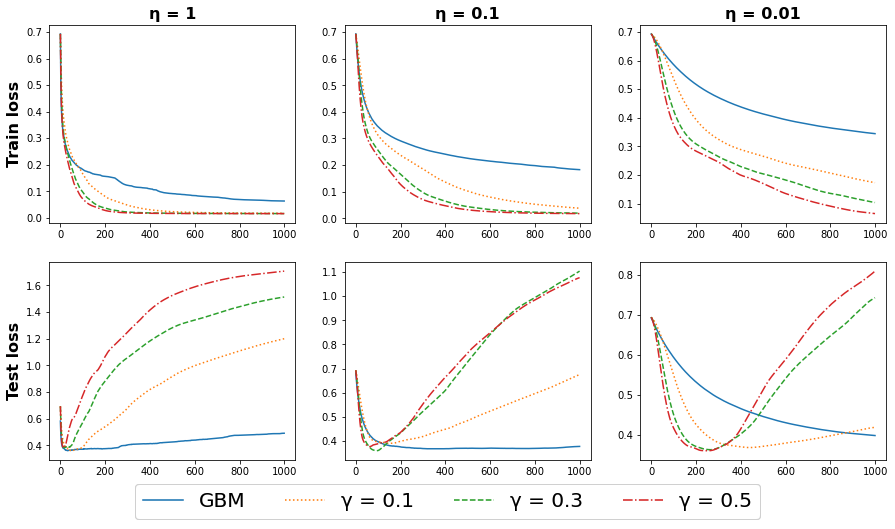

In [417]:
lr = [1,0.1,0.01] # initialization of learning rate's vector
fig, ax = plt.subplots(2,3,figsize=(15,8)) # creating the figure 
gamma_value = [0.1, 0.3, 0.5] # initialization of gamma's vector
linestyles = ['dotted', 'dashed', 'dashdot'] # linestyles

# Setting labels and titles for the plot
ax[0,0].set_ylabel('Train loss',fontsize=16,fontweight='bold')
ax[1,0].set_ylabel('Test loss',fontsize=16,fontweight='bold')

ax[0,0].set_title('\u03B7 = 1',fontsize=16,fontweight='bold')
ax[0,1].set_title('\u03B7 = 0.1',fontsize=16,fontweight='bold')
ax[0,2].set_title('\u03B7 = 0.01',fontsize=16,fontweight='bold')



# plotting iteratively the loss function of GBM and AGBM computed using different gamma values and learning rates

for rank, i in enumerate(lr):
    # computing train loss
    WLs_logit,lossVec_logit = fit_GBM(X_train, y_train,lr=i,is_regression = 0, nr_WL = 1000, depth = 4)
    # plotting the train loss 
    ax[0,rank].plot(lossVec_logit,label = 'GBM',linestyle = 'solid')
    
    # computing test loss
    lossVecPred_logit,pred_logit = predict_GBM(X_test,y_test,WLs_logit,is_regression = 0)
    # plotting test loss 
    ax[1,rank].plot(lossVecPred_logit,label = 'GBM',linestyle = 'solid')
    
    # plotting for AGBM
    for r,a in enumerate(gamma_value):
        
        # computing train loss 
        WLs_AGBM,lossVec_AGBM = fit_AGBM(X_train, y_train ,nr_WL=1000, depth=4, lr=i, gamma=a, is_regression=0)
        
        # plotting train loss
        ax[0,rank].plot(lossVec_AGBM, label = '\u03B3 = {}'.format(a),linestyle =linestyles[r])
        
        # computing test loss 
        lossVecPred_AGBM, ypred_AGBM = predict_AGBM(X_test, y_test,WLs_AGBM,lr=i, gamma=a, is_regression=0)
        
        # plotting test loss
        ax[1,rank].plot(lossVecPred_AGBM, label = '\u03B3 = {}'.format(a),linestyle =linestyles[r])    
        
        # adding a unique legend to the plot
    handles, labels = ax[1,rank].get_legend_handles_labels()
    fig.legend(handles, labels, loc = 'lower center',prop={"size":20},ncol =4)

        
# saving figure
plt.savefig('Risultati_LU')

In [418]:
# For different numbers of weak learners (n = 30, 50, 100), we fit for each dataset used in Lu et al. 2020 both GBM and AGBM
# the latter with parameter gamma = 0.3 (i.e. the median value of the ones adopted in the precedent experiment).

# NOTE: This is a major difference from the implementation of Lu et al. 2020. Indeed they implement a random search to find
# the best value of gamma. In our case, given that we use as weak learners (WL) decision trees from the scikit learn package
# instead of implementing WL from scratch as a class. Our implementation, differently from Lu's, makes doing random search 
# very tedious. 

# as  described in Lu et al. 2020, appendix A we fit each model on 5 different train-test splits in order to assess the 
# generalizability of the result. For each model we report the standard error of the mean (SEM) relative to those 5 splits.

for n in [30,50,100]:
    Loss_table(n)

   mean_AGBMLoss_TR  SEM_AGBMLoss_TR  mean_AGBMLoss_TE  SEM_AGBMLoss_TE  \
0          0.447043         0.006719          0.514363         0.040760   
1          0.486980         0.004925          0.557190         0.015512   
2          1.579539         0.106019          7.267460         2.651879   
3          0.238322         0.002273          0.243319         0.004033   
4          0.420137         0.004500          0.444639         0.015946   
5          0.264191         0.010314          0.529437         0.014636   

   mean_GBMLoss_TR  SEM_GBMLoss_TR  mean_GBMLoss_TE  SEM_GBMLoss_TE  
0         0.492629        0.005169         0.544750        0.020966  
1         0.525206        0.002946         0.574542        0.010400  
2         1.945719        0.121545         6.250314        1.881914  
3         0.326988        0.002345         0.325877        0.002626  
4         0.473298        0.003649         0.487305        0.008856  
5         0.343252        0.007818         0.541826   

### GBM VS RGBM

In [419]:
# data loading

X_a9a,y_a9a = initialize_data('a9a','txt')

X_colon,y_colon = initialize_data('colon-cancer','bz2')

X_rcv1,y_rcv1 = initialize_data('rcv1_train.binary','bz2')

X_Year, y_Year = initialize_data('YearPredictionMSD_t','bz2')


682 numero di iterazioni per j = 123
2127 numero di iterazioni per j = 36
5613 numero di iterazioni per j = 11
15921 numero di iterazioni per j = 3
23720 numero di iterazioni per j = 1


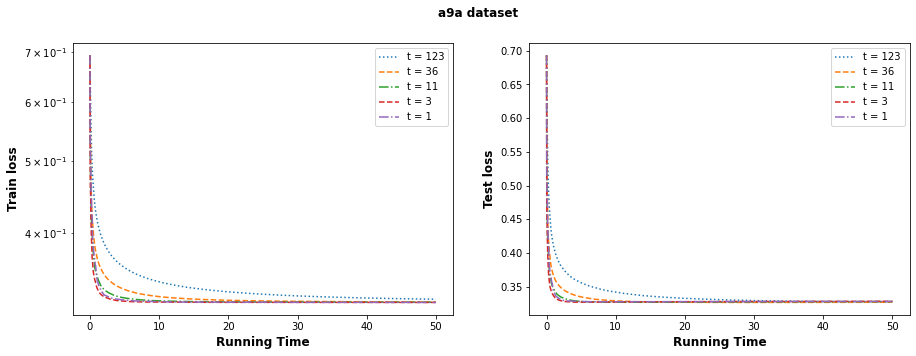

In [421]:
## a9a 

X_train_a9a,X_test_a9a,y_train_a9a,y_test_a9a = train_test_split(X_a9a, y_a9a, test_size=0.2, random_state=1)
linestyles = ['dotted', 'dashed', 'dashdot','dashed', 'dashdot']
t_value_a9a = [123,36,11,3,1]

training_testing_plot(X_train_a9a,y_train_a9a,X_test_a9a,y_test_a9a,t_value_a9a,lr = 4, reg = 0,secs= 50, data_name = 'a9a')

3236 numero di iterazioni per j = 2000
15686 numero di iterazioni per j = 299
37954 numero di iterazioni per j = 44
56042 numero di iterazioni per j = 6
52986 numero di iterazioni per j = 1


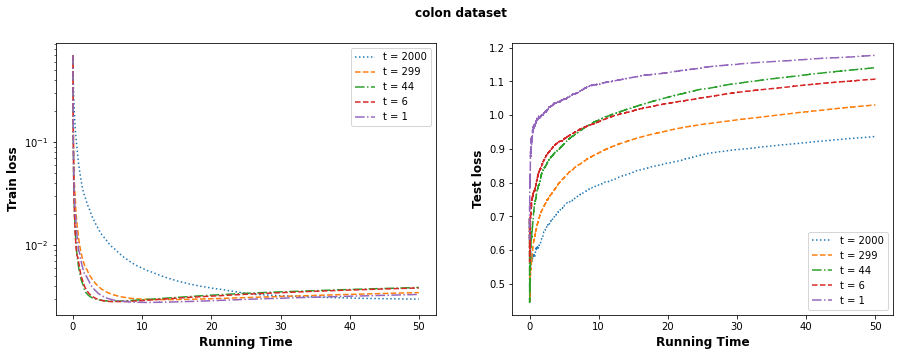

In [306]:
X_train_colon,X_test_colon,y_train_colon,y_test_colon = train_test_split(X_colon, y_colon, test_size=0.2, random_state=1)

t_value_colon = [2000,299,44,6,1]
training_testing_plot(X_train_colon,y_train_colon,X_test_colon,y_test_colon,t_value_colon,lr = 4 ,reg= 0,secs=50, data_name = 'colon')

15 numero di iterazioni per j = 47236
343 numero di iterazioni per j = 3204
5141 numero di iterazioni per j = 217
72930 numero di iterazioni per j = 14
536154 numero di iterazioni per j = 1


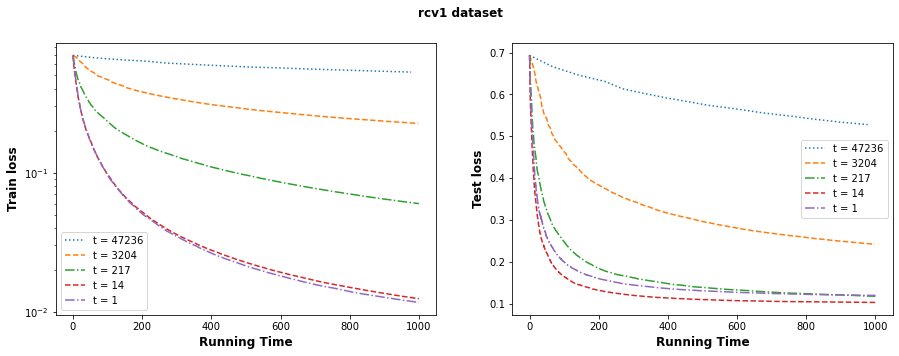

In [308]:
# rcv1
X_rcv1,y_rcv1 = initialize_data('rcv1_train.binary','bz2')
X_train_rcv1,X_test_rcv1,y_train_rcv1,y_test_rcv1 = train_test_split(X_rcv1, y_rcv1, test_size=0.2, random_state=1)

t_value_rcv1 = [47236,3204,217,14,1]
training_testing_plot(X_train_rcv1,y_train_rcv1,X_test_rcv1,y_test_rcv1,t_value_rcv1,lr = 4,reg = 0,secs= 1000 , data_name = 'rcv1')


In [ ]:
# year
X_year,y_year = initialize_data('YearPredictionMSD_t','bz2')
X_train_year,X_test_year,y_train_year,y_test_year = train_test_split(X_year, y_year, test_size=0.2, random_state=1)


t_value_year = [90,29,9,3,1]
training_testing_plot(X_train_year,y_train_year,X_test_year,y_test_year,t_value_year,lr = 1,reg = 1,secs = 200, data_name = 'year')


159 numero di iterazioni per j = 123
159 numero di iterazioni per j = 36
159 numero di iterazioni per j = 11
159 numero di iterazioni per j = 3
159 numero di iterazioni per j = 1


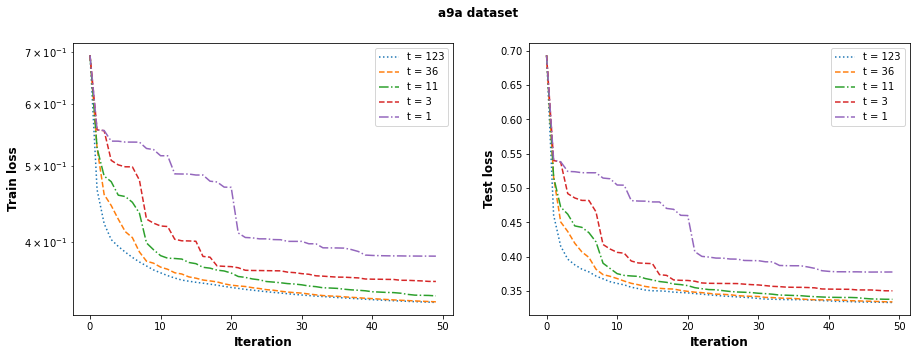

In [317]:
#### ITERATIONS A9A ####

fig, ax = plt.subplots(1,2,figsize=(15,5))
# Setting labels and titles for the plot
ax[0].set_ylabel('Train loss',fontsize=12,fontweight='bold')
ax[1].set_ylabel('Test loss',fontsize=12,fontweight='bold')
   
ax[0].set_xlabel('Iteration',fontsize=12,fontweight='bold')
ax[1].set_xlabel('Iteration',fontsize=12,fontweight='bold')

fig.suptitle('a9a dataset',fontsize=12,fontweight='bold')
for r,b in enumerate(t_value_a9a):
    WLs_RGBM, lossVec_RGBM = fit_RGBM(X_train_a9a, y_train_a9a ,nr_WL=50, depth=1,  j=b, is_regression=0,lr =4) 
    print('{} numero di iterazioni per j = {}'.format(iterazioni, b))
    ax[0].semilogy(lossVec_RGBM,label = 't = {}'.format(b),linestyle = linestyles[r])
    ax[0].legend(prop={"size":10})
    lossVecPred_RGBM, ypred_RGBM = predict_RGBM(X_test_a9a, y_test_a9a,WLs_RGBM, is_regression=0)
    plt.yscale('linear')
    ax[1].plot(lossVecPred_RGBM, label = 't = {}'.format(b),linestyle = linestyles[r])    
    ax[1].legend(prop={"size":10})

    plt.savefig('Risultati a9a iterations')